## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 1. Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

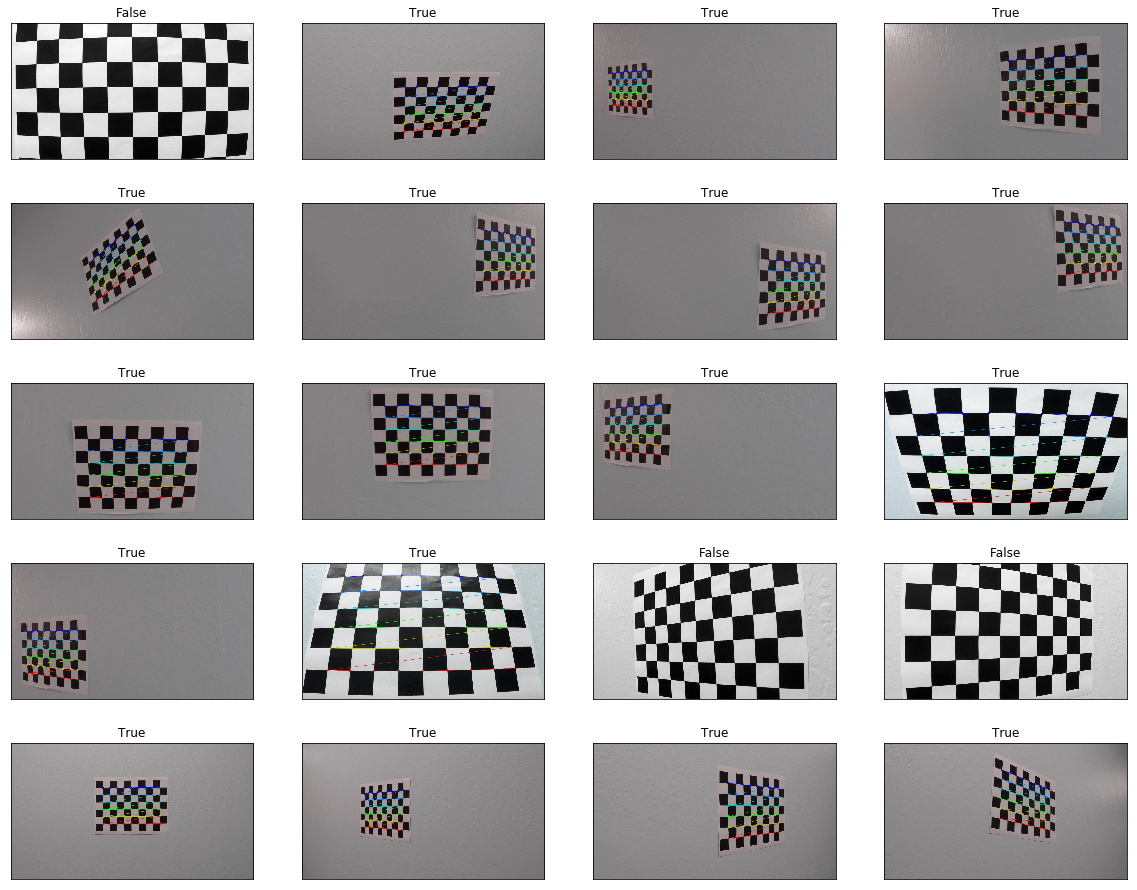

In [3]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

fig, ax = plt.subplots(ncols = 4, nrows = 5, figsize = (20, 16))
i = 0
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    # print(fname, img.shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # cv2.imshow('img',img)
        # cv2.waitKey(500)
        r = i % 4
        c = i // 4
        ax[c][r].imshow(img)
        ax[c][r].set_xticks(())
        ax[c][r].set_yticks(())
        ax[c][r].set_title(ret)
        i += 1
    else:
        r = i % 4
        c = i // 4
        ax[c][r].imshow(gray, cmap = 'gray')
        ax[c][r].set_xticks(())
        ax[c][r].set_yticks(())
        ax[c][r].set_title(ret)
        i += 1
plt.savefig('./output_images/chessboard_corners.jpg')
#cv2.destroyAllWindows()
# Save the chessboard corners result for later use 
chessboard_pickle = {}
chessboard_pickle["objpoints"] = objpoints
chessboard_pickle["imgpoints"] = imgpoints
pickle.dump(chessboard_pickle, open( "chessboard_corners.p", "wb" ) )

In [4]:
# Test undistortion on a calibration image
img = cv2.imread('./camera_cal/calibration3.jpg')
def undistort(img, objpoints, imgpoints, save_pkl = False):
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    if save_pkl:
        # Save the camera calibration result for later use
        dist_pickle = {}
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump(dist_pickle, open( "camera_calibration.p", "wb"))

    #Distortion correct the test image
    undist_img = cv2.undistort(img, mtx, dist, None, mtx)
    return undist_img
cal_undist = undistort(img, objpoints, imgpoints, save_pkl = True)
cv2.imwrite('./output_images/calibration3_undist.jpg',cal_undist)

True

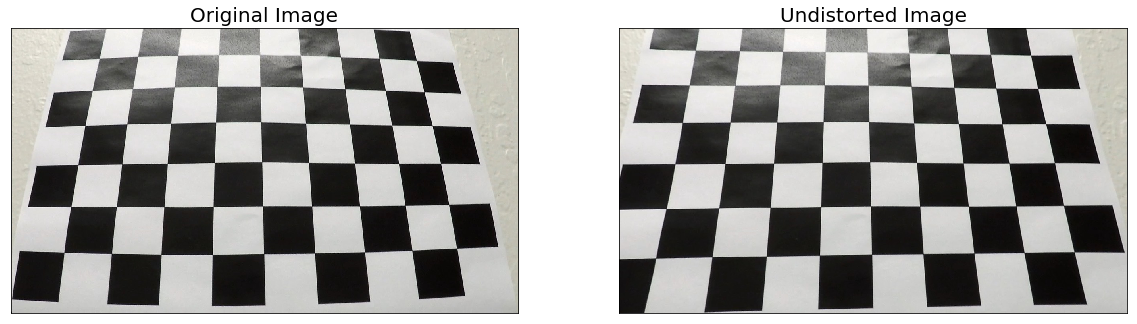

In [5]:
# Visualize undistortion
def visualize_undistort(img, undist_img, image_path, save_img = True):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #ax1.imshow(img);
    # convert from BGR to RGB for display
    ax1.imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB));
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax1.set_title('Original Image', fontsize=20);
    #ax2.imshow(undist_img);
    ax2.imshow(cv2.cvtColor(undist_img.copy(), cv2.COLOR_BGR2RGB));
    ax2.set_xticks(())
    ax2.set_yticks(())
    ax2.set_title('Undistorted Image', fontsize=20);
    if save_img:
        plt.savefig(image_path)
image_path = './output_images/camera_calibration.jpg'
visualize_undistort(img, cal_undist, image_path)

### 2. Pipeline (Single images)
#### 2.1 An example of distortion-corrected image

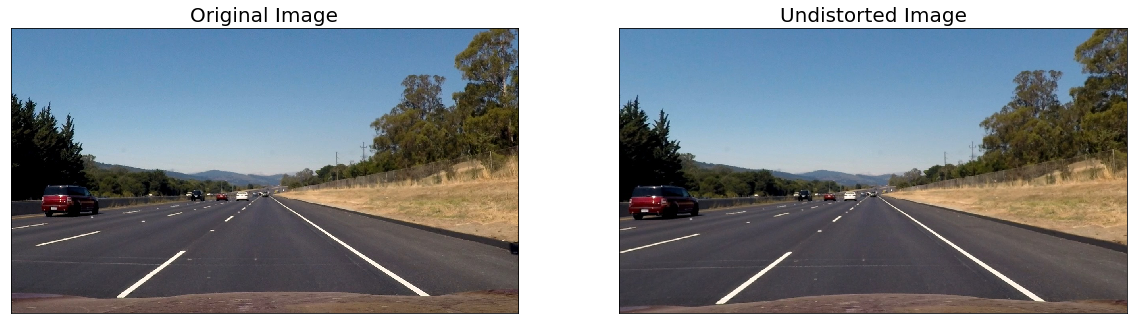

In [6]:
# Test undistortion on a calibration image
img = cv2.imread('./test_images/straight_lines2.jpg')
test_undist = undistort(img, objpoints, imgpoints)
image_path = './output_images/straight_lines2_undist.jpg'
visualize_undistort(img, test_undist, image_path, save_img = False)

### 2.2 Identify lane line pixels
#### 2.2.1 Sobel operators

In [17]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

In [28]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [97]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [177]:
# Define a function to use a combination of Sobel operators
def combined_sobel(img, ksize = 3, x_thresh = (0, 255), y_thresh = (0, 255), mag_thresh = (0, 255), dir_thresh = (0, np.pi/2.)):
    # Choose a Sobel kernel size
    # ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=x_thresh)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=y_thresh)
    mag_binary = mag_threshold(img, sobel_kernel=ksize, thresh=mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=dir_thresh)
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[(gradx == 1) & (grady == 1) | (dir_binary == 1) & (mag_binary == 1)] = 1
    #combined[(dir_binary == 1) & (mag_binary == 1)] = 1
    #combined = dir_binary
    return combined

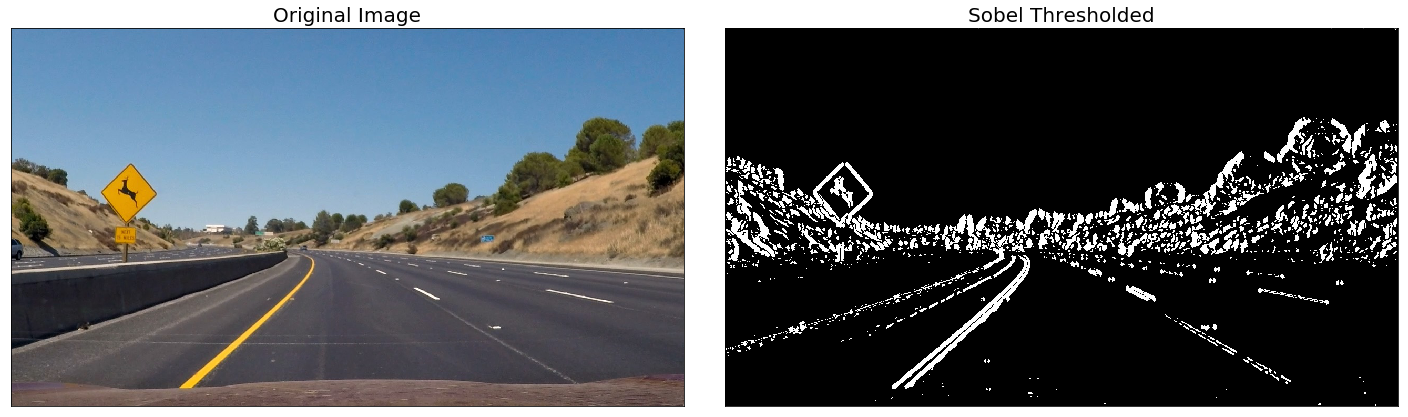

In [192]:
# Use a distortion-corrected test image 
img = cv2.imread('./test_images/test2.jpg')

# Run the function
combined = combined_sobel(img, ksize=25, x_thresh=(30, 200), y_thresh=(50, 255),dir_thresh=(0., 1.2), mag_thresh = (30, 255))
# Plot the result
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(20, 10))
fig.tight_layout()
ax[0].imshow(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB))
ax[0].set_title('Original Image', fontsize=20)
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[1].imshow(combined, cmap='gray')
ax[1].set_title('Sobel Thresholded', fontsize=20)
ax[1].set_xticks(())
ax[1].set_yticks(())
plt.savefig('./output_images/test2_sobel_threshold.jpg')